# LLHP

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
import millefeuille as mf
import pickle
from scipy import stats

In [2]:
parse_dims = ['x', 'y', 'z', 't', 'track_zenith', 'track_azimuth', 'energy', 'track_fraction']
def parse(stats):
    out = {}
    out['mean'] = {}
    out['std'] = {}
    out['mle'] = {}
    out['map'] = {}    
    stats = [s.strip() for s in stats]
    print '\n'.join(stats)
    res = stats[4:12]
    for r in res:
        dim, p, e = [float(x) for x in r.split()]
        out['mean'][parse_dims[int(dim)-1]] = p
        out['std'][parse_dims[int(dim)-1]] = e
    out['mean']['track_energy'] = out['mean']['energy'] * out['mean']['track_fraction']
    out['mean']['cascade_energy'] = out['mean']['energy'] * (1 - out['mean']['track_fraction'])
    out['std']['track_energy'] = out['std']['energy'] * out['mean']['track_fraction']
    out['std']['cascade_energy'] = out['std']['energy'] * (1 - out['mean']['track_fraction'])
    
    res = stats[15:23]
    for r in res:
        dim, p = [float(x) for x in r.split()]
        out['mle'][parse_dims[int(dim)-1]] = p
    out['mle']['track_energy'] = out['mle']['energy'] * out['mle']['track_fraction']
    out['mle']['cascade_energy'] = out['mle']['energy'] * (1 - out['mle']['track_fraction'])
    
    res = stats[26:34]
    for r in res:
        dim, p = [float(x) for x in r.split()]
        out['map'][parse_dims[int(dim)-1]] = p
    out['map']['track_energy'] = out['map']['energy'] * out['map']['track_fraction']
    out['map']['cascade_energy'] = out['map']['energy'] * (1 - out['map']['track_fraction'])
    
    return out

In [70]:
# this looks nice
#event = 190
#quite nice one
#event = 33
# this one's fucked
#event = 142
#this one's spot on 80 GeV
#event = 133
# a normal one
event = 7

#llhp_data = np.load('/data/justin/retro/recos/bare/upgoing_muon_t0/evt%i-llhp.npy'%event)
llhp_data = np.load('/data/justin/retro/recos/2018-03-26/1460/0/evt%i-llhp.npy'%event)

#for name in llhp_data.dtype.names:
#    llhp_data[name] = llhp_data[name].astype(np.float16)

# transalte fucked up dict
new_data = {'z':llhp_data['t'],
            'llh':llhp_data['llh'],
            'y':llhp_data['track_zenith'], 
            'x': llhp_data['cascade_energy'], 
            'cascade_energy':llhp_data['track_azimuth'],
            't':llhp_data['track_energy'],
            'track_energy':llhp_data['z'],
            'track_zenith' :  llhp_data['y'],
            'track_azimuth': llhp_data['x']}

#print llhp_data.dtype.names

new_names = ('llh', 'z', 'track_azimuth', 'track_zenith', 'track_energy', 'y', 'cascade_energy', 't', 'x')

llhp_data.dtype.names = new_names

#new_data = np.empty_like(llhp_data)
#new_data['z'] = llhp_data['t']

##names = new_data.keys()
#dtype = np.dtype([(n, np.float32) for n in names])
#new_data = np.array(new_data.values(), dtype=dtype)
#new_data = np.fromiter(new_data.iteritems(), dtype=dtype, count=len(new_data))


data = mf.DataStack('data')
llhp = mf.PointLayer(llhp_data, 'llhp')
data.add_layer(llhp)

#with open('/data/justin/retro/recos/bare/upgoing_muon_t0/evt%i-stats.dat'%event, 'r') as f:
with open('/data/justin/retro/recos/2018-03-26/1460/0/evt%i-stats.dat'%event, 'r') as f:
    mn_stats = f.readlines()
mn_stats = parse(mn_stats)

with open('/data/icecube/sim/ic86/retro/1460/0/mc_truth.pkl', 'rb') as f:
    truth = pickle.load(f)
    
truth = truth[event]
truth['track_azimuth'] = truth['azimuth']
truth['track_zenith'] = np.arccos(truth['coszen'])
truth['track_energy'] = truth['highest_energy_daughter_energy']
truth['t'] = truth['time']

Nested Sampling Global Log-Evidence           :   -0.728797278324210652E+03  +/-    0.354499237593390359E+00
Nested Importance Sampling Global Log-Evidence:   -0.731688587249932311E+03  +/-    0.104989147723792739E+00

Dim No.       Mean        Sigma
1    0.820301780163746486E+01    0.998083063695439598E+01
2   -0.151620219968530101E+02    0.946629418404157796E+01
3   -0.324413576842086684E+03    0.707233325455041850E+01
4    0.974338300817636264E+04    0.240921054725999717E+02
5    0.173428617091874671E+01    0.496327069277837762E+00
6    0.430897778965859590E+01    0.214099187249056255E+01
7    0.952910173753986456E+01    0.274470438230150249E+01
8    0.427040452775737933E+00    0.221490233040965462E+00

Maximum Likelihood Parameters
Dim No.        Parameter
1    0.875691159993073143E+01
2   -0.144675087901921415E+02
3   -0.320522710253806281E+03
4    0.976464527043899943E+04
5    0.155551940605052152E+01
6    0.598959669700747988E+01
7    0.898728513493842307E+01
8    0.344721942018

In [73]:
llhp_data['t']

array([  4696.39648438,  15396.50878906,   3684.21313477, ...,
         9748.55175781,   9746.73144531,   9764.78027344], dtype=float32)

In [74]:
np.percentile(data['llhp']['x'], 90)

33.179949951171878

In [75]:
bin_edges = OrderedDict()
lower_q = 10
upper_q = 90

dims = ['x', 'y', 'z', 't', 'track_zenith', 'track_azimuth', 'track_energy', 'cascade_energy']

for dim in dims:
    if dim == 'track_azimuth':
        mean = stats.circmean(data['llhp'][dim])
    else:
        mean = data['llhp'][dim].mean()
    std = data['llhp'][dim].std()
    #bin_edges[dim] = np.linspace(np.percentile(data['llhp'][dim], 10), np.percentile(data['llhp'][dim], 90), 101)
    bin_edges[dim] = np.linspace(mean - std, mean + std, 101)

bin_edges['x'] = np.linspace(truth['x'] - 50 , truth['x'] + 50, 101)
bin_edges['y'] = np.linspace(truth['y'] - 50 , truth['y'] + 50, 101)
bin_edges['z'] = np.linspace(truth['z'] - 50 , truth['z'] + 50, 101)
bin_edges['t'] = np.linspace(truth['t'] - 150 , truth['t'] + 150, 101)
bin_edges['track_azimuth'] = np.linspace(0, 2*np.pi, 101)
bin_edges['track_zenith'] = np.linspace(0, np.pi, 101)
bin_edges['track_energy'] = np.linspace(truth['track_energy']*0.2 , truth['track_energy']*2, 101)
bin_edges['cascade_energy'] = np.linspace(truth['cascade_energy']*0.2 , truth['cascade_energy']*2, 101)
binning = mf.Binning(bin_edges)

In [76]:
data.add_layer(mf.BinLayer(binning['x','y'], 'xy'))
data.add_layer(mf.BinLayer(binning['x','t'], 'xt'))
data.add_layer(mf.BinLayer(binning['x','z'], 'xz'))
data.add_layer(mf.BinLayer(binning['t','z'], 'tz'))
data.add_layer(mf.BinLayer(binning['track_azimuth','track_zenith'], 'azzen'))
data.add_layer(mf.BinLayer(binning['track_energy','track_zenith'], 'ezen'))
data.add_layer(mf.BinLayer(binning['t','track_energy'], 'ten'))
data.add_layer(mf.BinLayer(binning['t','track_zenith'], 'tzen'))
data.add_layer(mf.BinLayer(binning['cascade_energy','track_energy'], 'energy'))

In [77]:
binlayers = ['xy', 'tz', 'xt', 'xz', 'azzen', 'energy', 'ten', 'tzen', 'ezen']

In [78]:
for binlayer in binlayers:
    data.translate(var='llh', source='llhp', dest=binlayer, method='max')
    data.translate(var='llh', dest_var='count', source='llhp', dest=binlayer, method='count')
    data.translate(var='llh', dest_var='sum', source='llhp', dest=binlayer, method='sum')
    data.translate(var='llh', dest_var='mean', source='llhp', dest=binlayer, method='mean')
    data[binlayer]['sum'] = data[binlayer]['sum'] * -1
    data[binlayer]['mean'] = data[binlayer]['mean'] * -1

In [83]:
def plot_map(layer, ax, var='llh', best=True, truth=None, stats=None, estimator=None, **kwargs):
    X, Y = layer.meshgrid
    Z = layer[var].T
    ax.set_xlabel(layer.binning.bin_names[0])
    ax.set_ylabel(layer.binning.bin_names[1])
    pc = ax.pcolormesh(X, Y, Z, cmap='Spectral_r', **kwargs)
    plt.colorbar(pc, ax=ax, label=var)
    if best:
        best = np.where(Z==np.max(Z))
        ax.scatter(X[best], Y[best],c='w',marker='*')
        #print X[best], Y[best]
    if truth is not None:
        ax.scatter(truth[layer.binning.bin_names[0]],
                   truth[layer.binning.bin_names[1]],
                   100,
                   marker='+', c='cyan')
    if stats is not None:
        ax.errorbar(stats['mean'][layer.binning.bin_names[0]],
                    stats['mean'][layer.binning.bin_names[1]],
                    xerr=stats['std'][layer.binning.bin_names[0]],
                    yerr=stats['std'][layer.binning.bin_names[1]],
                    marker='.', c='k', ms=0.1)
        ax.errorbar(stats['mle'][layer.binning.bin_names[0]],
                    stats['mle'][layer.binning.bin_names[1]],
                    marker='*', c='w', ms=5)
        ax.errorbar(stats['map'][layer.binning.bin_names[0]],
                    stats['map'][layer.binning.bin_names[1]],
                    marker='x', c='k', ms=5)
    if estimator is not None:
        ax.errorbar(estimator['mean'][layer.binning.bin_names[0]],
                    estimator['mean'][layer.binning.bin_names[1]],
                    marker='o',
                    c='magenta',
                    ms=5)
        ax.errorbar(estimator['low'][layer.binning.bin_names[0]],
                    estimator['mean'][layer.binning.bin_names[1]],
                    marker='>',
                    c='magenta',
                    ms=5)
        ax.errorbar(estimator['high'][layer.binning.bin_names[0]],
                    estimator['mean'][layer.binning.bin_names[1]],
                    marker='<',
                    c='magenta',
                    ms=5)
        ax.errorbar(estimator['mean'][layer.binning.bin_names[0]],
                    estimator['low'][layer.binning.bin_names[1]],
                    marker='^',
                    c='magenta',
                    ms=5)
        ax.errorbar(estimator['mean'][layer.binning.bin_names[0]],
                    estimator['high'][layer.binning.bin_names[1]],
                    marker='v',
                    c='magenta',
                    ms=5)
    ax.set_xlim(layer.binning[0][0],layer.binning[0][-1])
    ax.set_ylim(layer.binning[1][0],layer.binning[1][-1])

In [89]:
def estimate(llhp, percentila_nd=0.95):
    '''
    Evaluate estimator for reconstruction quantities given
    the MultiNest points of LLH space exploration
    
    Paranters:
    llhp : structured nd array with columns `llh` + any reco quantities
    percentile_nd : float
        on what percentile of llh values to base the calculation on
    
    Returns : dict of estimated points incluing uncertainties
    '''
    
    columns = list(llhp.dtype.names)
    assert 'llh' in columns, 'llh not in %s'%columns
    columns.remove('llh')
    
    nd = len(columns)
    
    # keep best LLHs
    cut = llhp['llh'] > llhp['llh'].max() - stats.chi2.ppf(percentile_nd, nd)

    estimator = {}
    estimator['mean'] = {}
    estimator['low'] = {}
    estimator['high'] = {}

    # cut away upper and lower 13.35% to arrive at 1 sigma
    percentile = (percentile_nd - 0.682689492137086) / 2. * 100.

    for col in columns:
        var = llhp[col][cut]
        if 'azimuth' in col:
            # azimuth is a cyclic function, so need some special treatement to get correct mean
            mean = stats.circmean(var)
            shifted = (var - mean + np.pi)%(2*np.pi)
            low = (np.percentile(shifted, percentile) + mean - np.pi)%(2*np.pi)
            high = (np.percentile(shifted, 100-percentile) + mean - np.pi)%(2*np.pi)
        else:
            mean = var.mean()
            low = np.percentile(var, percentile)
            high = np.percentile(var, 100-percentile)
        estimator['mean'][col] = mean
        estimator['low'][col] = low
        estimator['high'][col] = high
    return estimator

In [90]:
estimator = estimate(data['llhp'].data)

{'high': {'track_energy': 7.3627142423778169, 't': 9768.3332909014771, 'track_zenith': 2.251207417549991, 'track_azimuth': 0.42100951061648217, 'y': -4.8058372729085868, 'x': 18.068859012495739, 'z': -315.76894890261019, 'cascade_energy': 8.9576101179072118}, 'low': {'track_energy': 1.3999173140438335, 't': 9721.840074907841, 'track_zenith': 1.1439396156156736, 'track_azimuth': 4.7973164920864795, 'y': -24.477132107028577, 'x': -1.6752258098017692, 'z': -331.37962422450994, 'cascade_energy': 2.2796340563949422}, 'mean': {'track_energy': 4.2877712, 't': 9744.7305, 'track_zenith': 1.6845919, 'track_azimuth': 5.7665142456637781, 'y': -14.77736, 'x': 8.2578335, 'z': -323.55746, 'cascade_energy': 5.5061436}}


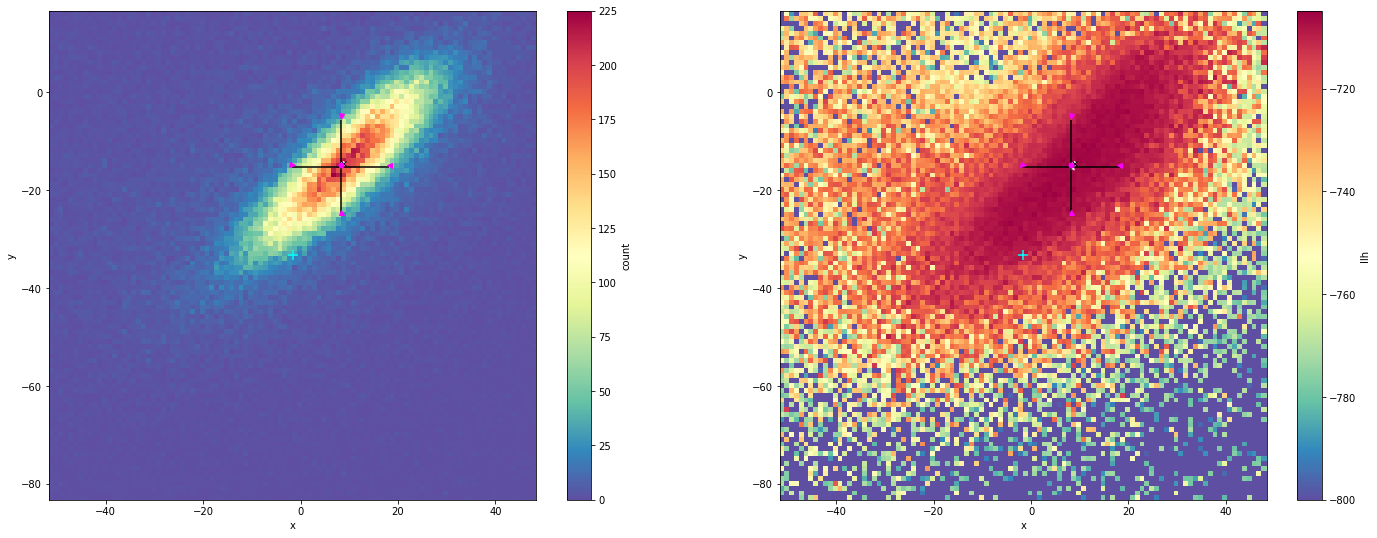

In [92]:
fig, axes = plt.subplots(figsize=(24, 9), ncols=2, nrows=1)
layer = 'xy'
plot_map(data[layer], axes[0], var='count', vmin =0, truth=truth, stats=mn_stats, best=False, estimator=estimator)
plot_map(data[layer], axes[1], var='llh', vmin=-800, truth=truth, stats=mn_stats, best=True, estimator=estimator)

In [93]:
truth

OrderedDict([('pdg', -14),
             ('x', -1.6243418547163628),
             ('y', -33.26235988159584),
             ('z', -322.3090416721935),
             ('time', 9703.898710012427),
             ('energy', 27.591073867038787),
             ('coszen', 0.076492925469874171),
             ('azimuth', 5.750489280921592),
             ('unique_id', 140000010010993),
             ('highest_energy_daughter_pdg', -13),
             ('highest_energy_daughter_energy', 2.63779068580149),
             ('highest_energy_daughter_length', 12.66724472488329),
             ('highest_energy_daughter_coszen', 0.29591055726515625),
             ('highest_energy_daughter_azimuth', 5.704617033168214),
             ('longest_daughter_pdg', -13),
             ('longest_daughter_energy', 2.63779068580149),
             ('longest_daughter_length', 12.66724472488329),
             ('longest_daughter_coszen', 0.29591055726515625),
             ('longest_daughter_azimuth', 5.704617033168214),
             

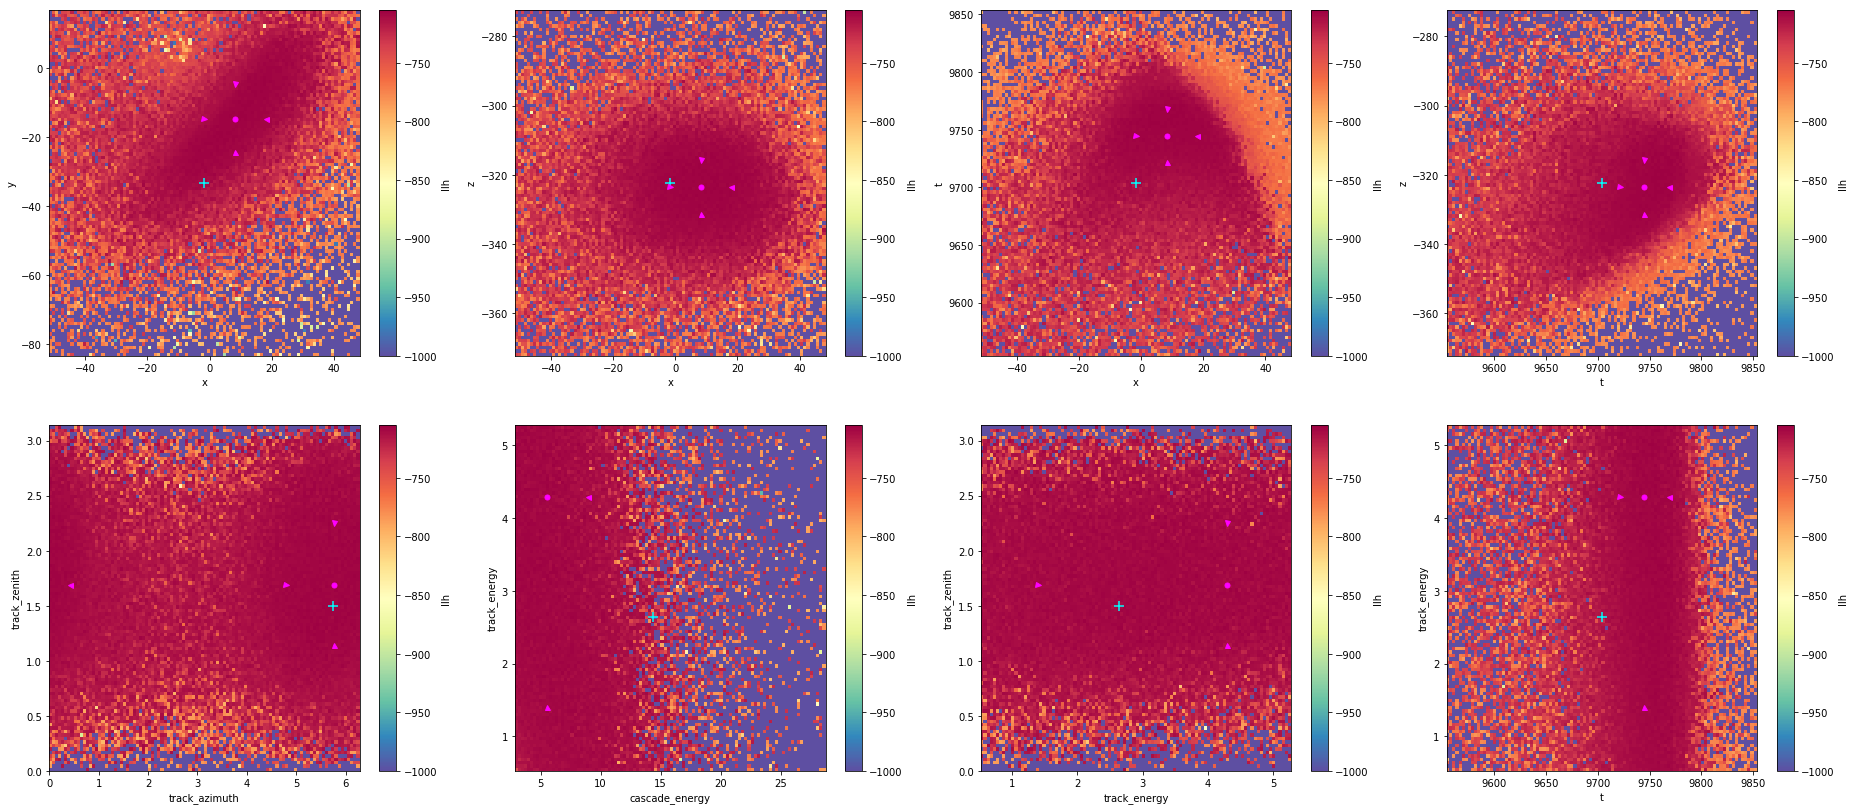

In [95]:
fig, axes = plt.subplots(figsize=(32, 14), ncols=4, nrows=2)
kwargs = {'vmin':-1000, 'truth':truth, 'estimator':estimator, 'best':False} #, 'stats': mn_stats}
plot_map(data['xy'], axes[0,0], **kwargs)
plot_map(data['xz'], axes[0,1], **kwargs)
plot_map(data['xt'], axes[0,2], **kwargs)
plot_map(data['tz'], axes[0,3], **kwargs)
plot_map(data['azzen'], axes[1,0], **kwargs)
plot_map(data['energy'], axes[1,1], **kwargs)
plot_map(data['ezen'], axes[1,2], **kwargs)
plot_map(data['ten'], axes[1,3], **kwargs)

In [880]:
mn_stats

{'map': {'cascade_energy': 5.889170749745944,
  'energy': 8.987285134938423,
  't': 9764.645270439,
  'track_azimuth': 5.98959669700748,
  'track_energy': 3.0981143851924804,
  'track_fraction': 0.3447219420187793,
  'track_zenith': 1.5555194060505215,
  'x': 8.756911599930731,
  'y': -14.467508790192142,
  'z': -320.5227102538063},
 'mean': {'cascade_energy': 5.45978981699477,
  'energy': 9.529101737539865,
  't': 9743.383008176363,
  'track_azimuth': 4.308977789658596,
  'track_energy': 4.069311920545095,
  'track_fraction': 0.42704045277573793,
  'track_zenith': 1.7342861709187467,
  'x': 8.203017801637465,
  'y': -15.16202199685301,
  'z': -324.4135768420867},
 'mle': {'cascade_energy': 5.889170749745944,
  'energy': 8.987285134938423,
  't': 9764.645270439,
  'track_azimuth': 5.98959669700748,
  'track_energy': 3.0981143851924804,
  'track_fraction': 0.3447219420187793,
  'track_zenith': 1.5555194060505215,
  'x': 8.756911599930731,
  'y': -14.467508790192142,
  'z': -320.52271025